# Portfolio Selection

*Efficient Diversification of Investments*

In this notebook we are going to have a look at the "Portfolio Selection" by Harry M. Markowitz and how we can use it to construct a portfolio.

Harry Markowitz is a Nobel Memorial Prize-winning economist who devised the modern portfolio theory in 1952. He describes different techniques for analysis of portfolios of securities. Modern portfolio theory argues that an investment's risk and return characteristics should not be viewed alone, but should be evaluated by how the investment affects the overall portfolio's risk and return.

#### Exploring the Efficient Frontier

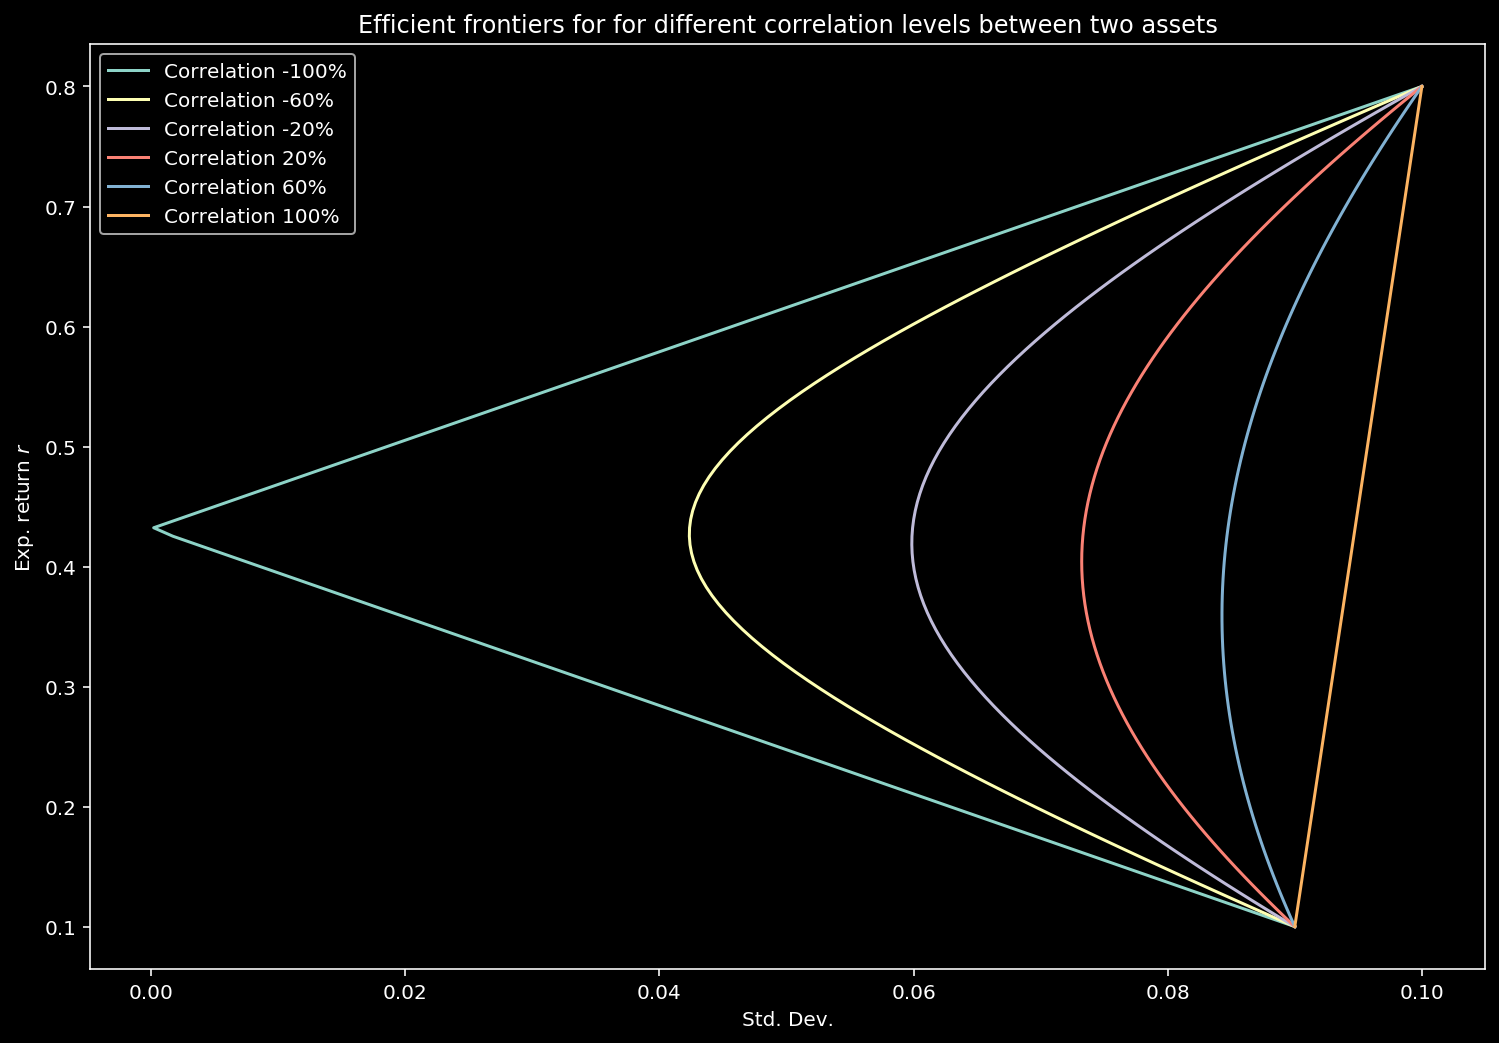

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
#%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.pylabtools import figsize
figsize(12.5, 8.5)
import scipy as sp
import statsmodels.api as sm
import statsmodels.api as sm 
import statsmodels.formula.api as sm
from statsmodels.iolib.summary2 import summary_col
import pandas.util.testing as tm
r_a = 0.10
r_b = 0.8
stdev_a = 0.09
stdev_b = 0.10


for correl in np.linspace(-1,1,6):
    X, Y = [], []
    for w_a in np.linspace(0,1,100):
        w_b = 1 - w_a
        r = r_a * w_a + r_b * w_b
        var = w_a**2 * stdev_a**2 + w_b**2 * stdev_b**2 + 2*w_a*w_b*stdev_a*stdev_b*correl
        stdev = np.sqrt(var)
        X.append(stdev)
        Y.append(r)
    plt.plot(X,Y,label='Correlation %0.0f%%' % (100*correl))

plt.xlabel('Std. Dev.'), plt.ylabel('Exp. return $r$')
plt.title('Efficient frontiers for for different correlation levels between two assets')
plt.legend();

#  Portfolio

## Top Absolute Correlations

To understand the role of correlations and efficient diversification we analyse the correlations of returns.

In [19]:
import sys
sys.path.insert(0, '../scripts/')

from database import Stock

import numpy as np
import datetime as dt
import pandas as pd
pd.set_option('display.max_rows', None)
from urllib.parse import urlencode
from yahoo_fin import stock_info as si

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)
plt.style.use('dark_background')
num_of_years = 1
start = dt.date.today() - dt.timedelta(days = int(365.25*num_of_years))
end = dt.date.today()

# tickers from our initial portfolio + Activision Blizzard 
tickers = ['TTWO', '7CD.F', 'GME', 'ATVI']

In [20]:
tmp_ = dict()

for tic in tickers:
    stk = Stock(tic, start, end).df
    tmp_[tic] = stk["Close"]

In [21]:
df_stks = pd.DataFrame(tmp_)
stk_rets  = np.log(df_stks/df_stks.shift(1)).dropna()

In [22]:
print('\nCorrelation Matrix')
corr_matrix = stk_rets.corr()
print (corr_matrix)


Correlation Matrix
           TTWO     7CD.F       GME      ATVI
TTWO   1.000000  0.165904  0.010003  0.742096
7CD.F  0.165904  1.000000  0.206502  0.147767
GME    0.010003  0.206502  1.000000 -0.020168
ATVI   0.742096  0.147767 -0.020168  1.000000


In [23]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

print("\nTop Absolute Correlations")
print(get_top_abs_correlations(stk_rets))


Top Absolute Correlations
TTWO   ATVI     0.742096
7CD.F  GME      0.206502
TTWO   7CD.F    0.165904
7CD.F  ATVI     0.147767
GME    ATVI     0.020168
TTWO   GME      0.010003
dtype: float64


## Compare Stocks with Scatter Plot

Text(0, 0.5, 'Activision Blizzard, Inc.')

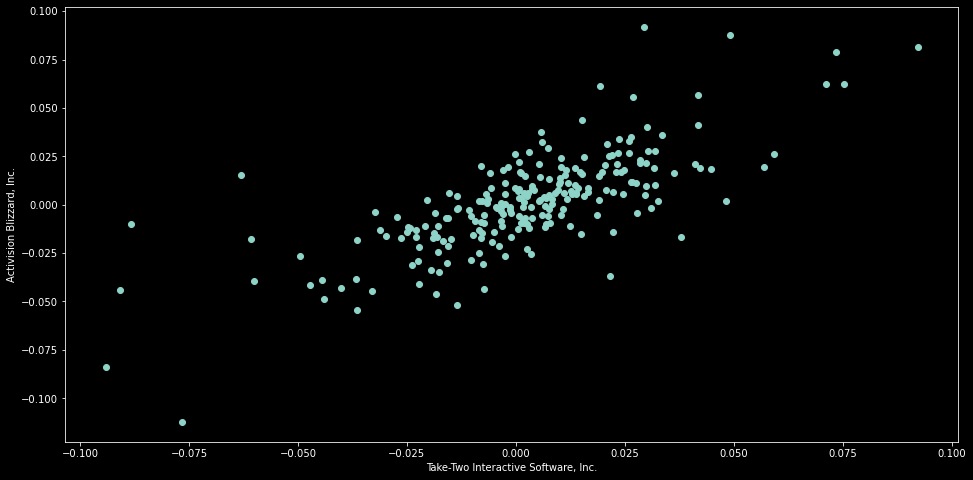

In [24]:
plt.scatter(stk_rets.TTWO, stk_rets.ATVI);
plt.xlabel('Take-Two Interactive Software, Inc.')
plt.ylabel('Activision Blizzard, Inc.')

Text(0, 0.5, 'GameStop Corp.')

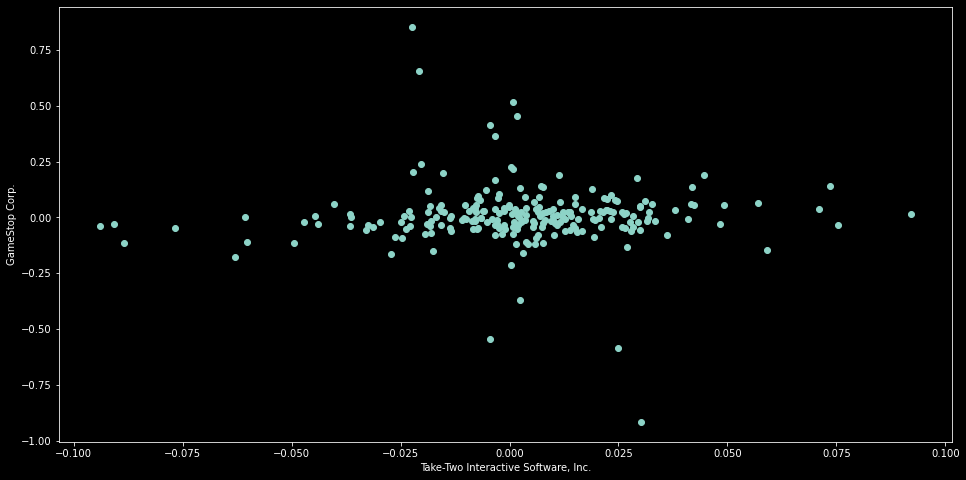

In [25]:
plt.scatter(stk_rets.TTWO, stk_rets.GME);
plt.xlabel('Take-Two Interactive Software, Inc.')
plt.ylabel('GameStop Corp.')

# The Efficient Frontier

lets pick 5 random ticker from our dow jones portfolio.

In [26]:
list(tickers)

['TTWO', '7CD.F', 'GME', 'ATVI']

In [27]:
assets=df_stks
returns = (assets/assets.shift(1))-1

log_returns = np.log((assets/assets.shift(1)))
log_returns_means = log_returns.mean()*252

cov_mat = log_returns.cov()*252
corr_mat = log_returns.corr()

In [28]:
#set seed for reproduceable results
np.random.seed(600)
number_port = 25000
number_assets = len(assets.columns)

#array to store weights
weights_store = np.zeros((number_port,len(assets.columns)))

#array to store returns
returns_store = np.zeros(number_port)

#array to store returns
vol_store = np.zeros(number_port)

#array to store Sharpe Ratio info
sharpe_store=np.zeros(number_port)

#set Riskfree Rate, necessary for sharpe ratio
Rf = 0

for x in range(number_port):
    #Weights
    weights = np.array(np.random.random(number_assets))
    weights /= np.sum(weights)
    #Save Weights
    weights_store[x,:] = weights
    
    #Save Expected Returns
    returns_store[x] = np.sum(weights*log_returns.mean())*252
   
    #Save Expected Volatility
    vol_store[x] = np.sqrt(np.dot(weights.T,np.dot(log_returns.cov()*252, weights)))
   
    #Save Sharpe Ratio
    sharpe_store[x] = (returns_store[x] - Rf)/vol_store[x]
    
print('Max Sharpe Ratio:',sharpe_store.max(),'Min Vol:',vol_store.min())

Max Sharpe Ratio: 1.8658158696273177 Min Vol: 0.3433648841402598


In [29]:
#Find location and allocation of Max Sharpe portfolio
max_sharpe_idx = np.argmax(sharpe_store)
max_sharpe_return = returns_store[max_sharpe_idx]
max_sharpe_vol = vol_store[max_sharpe_idx]
max_sharpe_wght = weights_store[max_sharpe_idx]

max_sharpe_allocation = pd.DataFrame(weights_store[max_sharpe_idx],index=returns.columns,columns=['Max_Sharpe_Allocation'])
max_sharpe_allocation.Max_Sharpe_Allocation = [round(i*100,2)for i in max_sharpe_allocation.Max_Sharpe_Allocation]
max_sharpe_allocation = max_sharpe_allocation.T
max_sharpe_allocation

,TTWO,7CD.F,GME,ATVI
Max_Sharpe_Allocation,67.25,0.3,7.53,24.92


In [30]:
#Find location and allocation of Min Vol portfolio
min_vol_idx = np.argmin(vol_store)
min_vol_return = returns_store[min_vol_idx]
min_vol_vol = vol_store[min_vol_idx]
min_vol_allocation = pd.DataFrame(weights_store[min_vol_idx],index=returns.columns,columns=['Min_Vol_Allocation'])
min_vol_allocation.Min_Vol_Allocation = [round(i*100,2)for i in min_vol_allocation.Min_Vol_Allocation]
min_vol_allocation = min_vol_allocation.T
min_vol_allocation

,TTWO,7CD.F,GME,ATVI
Min_Vol_Allocation,33.91,21.88,1.19,43.02


In [31]:
print('Max Sharpe Portfolio Returns = ',max_sharpe_return)
print('Max Sharpe Portfolio Vol = ',max_sharpe_vol)

Max Sharpe Portfolio Returns =  0.7304635106751006
Max Sharpe Portfolio Vol =  0.3914981765167455


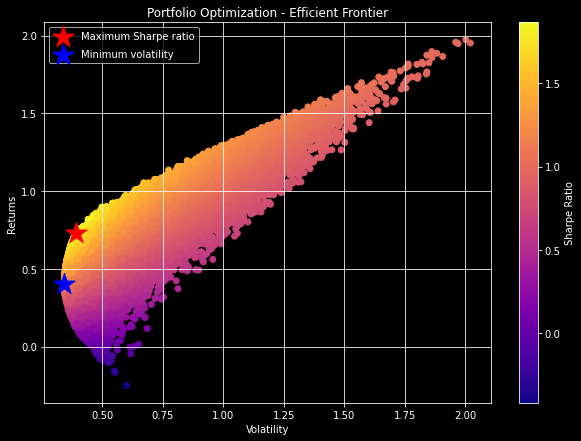

In [32]:
plt.figure(figsize=(10, 7))
#Assign data to axis, Vol,Returns, C= Sharpe Ratio, Cmap = 'Style'
plt.scatter(vol_store,returns_store,c=sharpe_store,cmap='plasma')
#Label Colorbar
plt.colorbar(label='Sharpe Ratio')
#Label Maximum Sharpe and Minimum Vol
plt.scatter(max_sharpe_vol,max_sharpe_return,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
plt.scatter(min_vol_vol,min_vol_return,marker='*',color='b',s=500, label='Minimum volatility')
#Provide a title
plt.title('Portfolio Optimization - Efficient Frontier')
plt.grid(True)
#Label X and Y Access
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.legend(labelspacing=0.8)
plt.show()

# Value at Risk

Value at risk (VaR) is a statistic used to try and quantify the level of financial risk within a firm or portfolio over a specified time frame. VaR provides an estimate of the maximum loss from a given position or portfolio over a period of time, and you can calculate it across various confidence levels.


So lets imagine we buy the portfolio one time with high sharpe weights (high risk) and one time with the low volatility weights (low risk). What is our maximum loss we can expect from the portfolio?

### High Risk VaR

In [33]:
weight_high_sharpe = np.array([62.21, 0.39, 9.53, 27.88])
t = np.sum(weight_high_sharpe)
weights_high_sharpe = weight_high_sharpe/t

In [34]:
initial_investment = 10000

returns = assets.pct_change()
cov_matrix = returns.cov()
weights = weights_high_sharpe
# Calculate mean returns for each stock
avg_rets = returns.mean()

# Calculate mean returns for portfolio overall, 
# using dot product to 
# normalize individual means against investment weights
port_mean = avg_rets.dot(weights)

# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Calculate mean of investment
mean_investment = (1+port_mean) * initial_investment    

# Calculate standard deviation of investmnet
stdev_investment = initial_investment * port_stdev

# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our portfolio
from scipy.stats import norm
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
print(var_1d1)

389.0792991063081


1 day VaR @ 95% confidence: 389.08
2 day VaR @ 95% confidence: 550.24
3 day VaR @ 95% confidence: 673.91
4 day VaR @ 95% confidence: 778.16
5 day VaR @ 95% confidence: 870.01


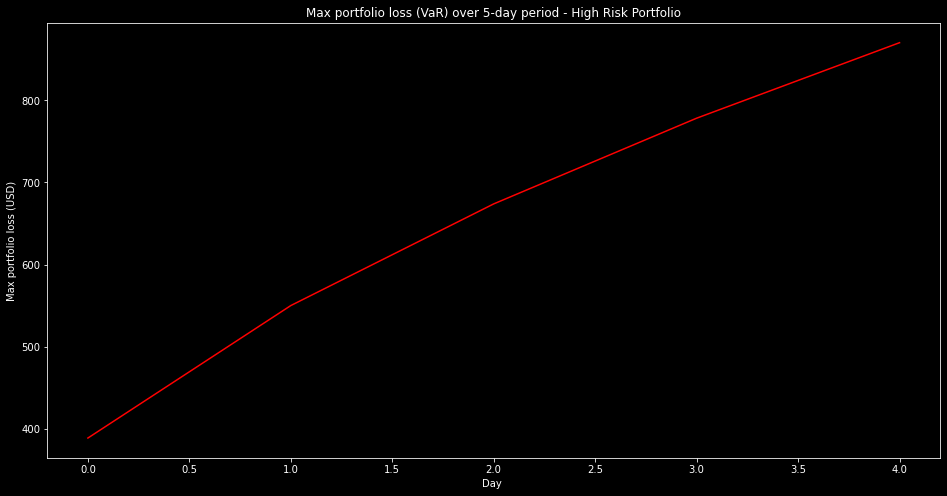

In [35]:
# Calculate n Day VaR
var_array = []
num_days = int(5)
for x in range(1, num_days+1):    
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

plt.xlabel("Day ")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 5-day period - High Risk Portfolio")
plt.plot(var_array, "r")

### Low Risk VaR

In [36]:

weight_low_vol = np.array([38.47, 20.89, 1.16 , 39.48])
t = np.sum(weight_low_vol )
weights_low_vol  = weight_low_vol /t

In [37]:
initial_investment = 10000

returns = assets.pct_change()
cov_matrix = returns.cov()
weights = weights_low_vol
# Calculate mean returns for each stock
avg_rets = returns.mean()

# Calculate mean returns for portfolio overall, 
# using dot product to 
# normalize individual means against investment weights
port_mean = avg_rets.dot(weights)

# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Calculate mean of investment
mean_investment = (1+port_mean) * initial_investment    

# Calculate standard deviation of investmnet
stdev_investment = initial_investment * port_stdev

# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our portfolio
from scipy.stats import norm
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
print(var_1d1)

330.44813118881575


1 day VaR @ 95% confidence: 330.45
2 day VaR @ 95% confidence: 467.32
3 day VaR @ 95% confidence: 572.35
4 day VaR @ 95% confidence: 660.9
5 day VaR @ 95% confidence: 738.9


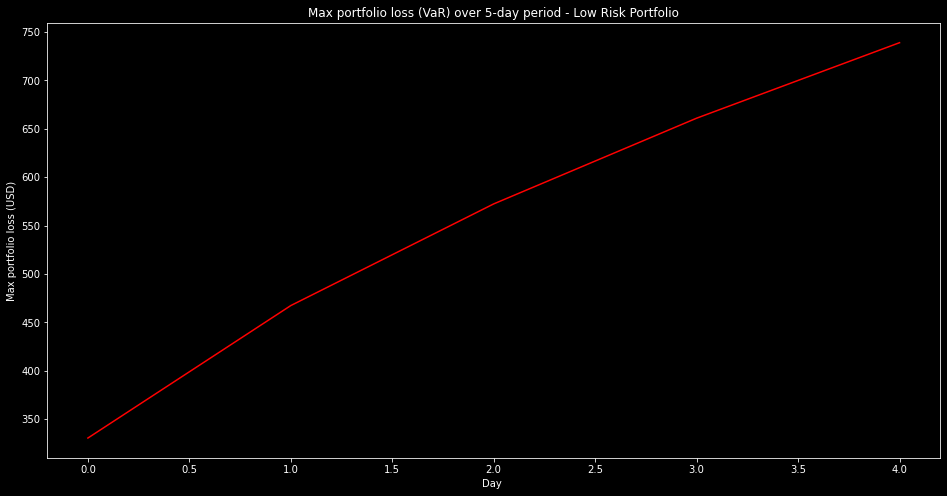

In [38]:
# Calculate n Day VaR
var_array = []
num_days = int(5)
for x in range(1, num_days+1):    
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

plt.xlabel("Day ")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 5-day period - Low Risk Portfolio")
plt.plot(var_array, "r")